---
title: Callback
categories: deep-learning
date: 2020-11-09
---

本文将介绍Tensorflow中的Callback。它是一个非常有用的工具，用于自定义train，evaluate和predict中的行为。

## Callback的方法

实现Callback很简单，主要有两步：

- 创建一个新的类，这个类继承`tf.keras.callbacks.Callback`。

- 根据需求，重载`tf.keras.callbacks.Callback`中的如下方法。
  - `on_(train|test|predict)_begin(self, logs=None)`
  - `on_(train|test|predict)_end(self, logs=None)`
  - `on_(train|test|predict)_batch_begin(self, batch, logs=None)`
  - `on_(train|test|predict)_batch_end(self, batch, logs=None)`
  - `on_epoch_begin(self, epoch, logs=None)`
  - `on_epoch_end(self, epoch, logs=None)`

  以上所有`begin`结尾方法，其logs是一个空的list。而end结尾的方法，其logs大多是有内容的，详见后文。

完成了前两步准备后，在模型训练，评估或预测时，把Callback类传入，则上面的那些方法将会被调用。其调用的具体的规则如下。

- `tf.keras.Model.fit()`

  Callback中方法调用顺序的伪代码如下。

  ~~~python
  on_train_begin(self, logs=None)
  for epoch in epoches:
  	on_epoch_begin(self, epoch, logs=None)
      for batch in train_batches:
          on_train_batch_begin(self, batch, logs=None)
          on_train_batch_end(self, batch, logs=None) 	# logs.keys = [loss, ...]        
      on_test_begin(self, logs=None)
      for batch in test_batches:
          on_test_batch_begin(self, batch, logs=None)
          on_test_batch_end(self, batch, logs=None)	 # logs.keys = [loss, ...]
      on_test_end(self, logs=None)	# logs.keys = [loss, ...]    
      on_epoch_end(self, epoch, logs=None)	# logs.keys = [loss, val_loss, ...]
  on_train_end(self, logs=None)	# logs.keys = [loss, val_loss, ...]
  ~~~

- `tf.keras.Model.evaluate()`

  Callback中方法调用顺序的伪代码如下。

  ~~~python
  on_test_begin(self, logs=None)
  for batch in test_batches:
  	on_test_batch_begin(self, batch, logs=None)			
      on_test_batch_end(self, batch, logs=None)   	# logs.keys = [loss, ...] 
  on_test_end(self, logs=None)	# logs.keys = [loss, val_loss, ...]
  ~~~

- `tf.keras.Model.predict()`

  Callback中方法调用顺序的伪代码如下。

  ~~~python
  on_predict_begin(self, logs=None)
  for batch in test_batches:
  	on_predict_batch_begin(self, batch, logs=None)	
  	on_predict_batch_end(self, batch, logs=None)	# logs = [outputs, ...] 
  on_predict_end(self, logs=None)
  ~~~

## Callback实践

### 调用顺序

下面的代码展示了Callback中方法的调用顺序。首先创建模型和加载数据。

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

def get_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(10))    
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()],
    )
    return model

def get_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    return x_train, y_train, x_test, y_test


然后自定义Callback类。

In [5]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("    Predicting: end of batch {}; got log keys: {}".format(batch, keys))


下面来进行模型训练，评估和预测。

In [6]:
x_train, y_train, x_test, y_test = get_mnist()
x_train = x_train[:1024]
y_train = y_train[:1024]
x_test = x_test[:512]
y_test = y_test[:512]

model = get_model()
model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=1,
    verbose=0,
    validation_split=0.5,
    callbacks=[CustomCallback()],
)

print('-'*100)
res = model.evaluate(
    x_test, y_test, batch_size=256, verbose=0, callbacks=[CustomCallback()]
)

print('-'*100)
res = model.predict(x_test, batch_size=256, callbacks=[CustomCallback()])

Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
    Training: start of batch 0; got log keys: []
    Training: end of batch 0; got log keys: ['loss', 'sparse_categorical_accuracy']
    Training: start of batch 1; got log keys: []
    Training: end of batch 1; got log keys: ['loss', 'sparse_categorical_accuracy']
Start testing; got log keys: []
    Evaluating: start of batch 0; got log keys: []
    Evaluating: end of batch 0; got log keys: ['loss', 'sparse_categorical_accuracy']
    Evaluating: start of batch 1; got log keys: []
    Evaluating: end of batch 1; got log keys: ['loss', 'sparse_categorical_accuracy']
Stop testing; got log keys: ['loss', 'sparse_categorical_accuracy']
End epoch 0 of training; got log keys: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']
Stop training; got log keys: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']
--------------------------------------

![image-20201108175730619](images/image-20201108175730619.png)

### Early Stopping

在模型训练时，为了减少过拟合，往往会采用Early Stopping的技术。它会比较某一个metrics（最常用的是`val_loss`）是否在持续在降低，如果连续几个epochs都没有降低，将会中止训练，而且往往会把参数恢复到之前metrics最低时候的参数。

下面自定义的类实现了Early Stopping的逻辑。下面代码中，当设置`self.model.stop_training = True`后，训练将会退出。

In [7]:
class MyEarlyStopping(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(MyEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.best_epoch = -1

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.best_epoch = epoch
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch {}.".format(self.best_epoch+1))
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
            
model = get_model()
history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=30,
    verbose=0,
    validation_split=0.5,
    callbacks=[MyEarlyStopping(patience=5)],    
)

Restoring model weights from the end of the best epoch 12.
Epoch 00017: early stopping


![image-20201109022827577](images/image-20201109022827577.png)

下面来显示训练过程中的val_loss趋势。

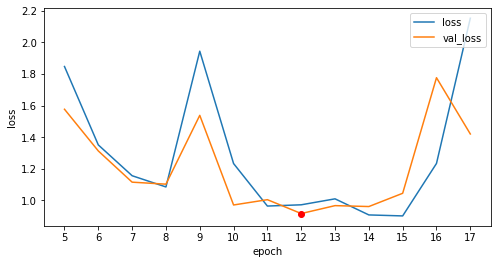

In [8]:
def plot_history(history, metrics_name='accuracy'):
    plt.figure(figsize=(8, 4))
    # 忽略前面几个epoch
    start_epoch = 5    
    metrics = history.history[metrics_name][start_epoch-1:]
    val_metrics = history.history['val_' + metrics_name][start_epoch-1:]
    epochs = [start_epoch + i for i in range(len(metrics))]
    lowest = np.argmin(val_metrics)
    
    plt.plot(epochs, metrics, label=metrics_name)
    plt.plot(epochs, val_metrics, label = 'val_' + metrics_name)
    plt.plot(lowest+start_epoch, val_metrics[lowest], 'ro')
    plt.xlabel('epoch')
    plt.ylabel(metrics_name)
    plt.xticks(epochs)
    plt.legend(loc='upper right')
    plt.show()

plot_history(history, metrics_name='loss')

![image-20201109023043836](images/image-20201109023043836.png)

上图中第15 epoch，val_loss获得最低的值，接下来五轮epoch，val_loss无法获得更低的值，所以训练退出。

TensorFlow在tf.keras.callbacks.EarlyStopping类中也实现的Early Stopping功能，其逻辑和上面的实现基本相同。

In [9]:
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=0, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=False
)

如果调用`keras.callbacks.EarlyStopping`，效果完全一样。

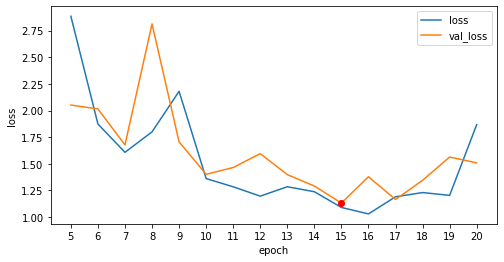

<function print>

In [10]:
model = get_model()
history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=30,
    verbose=0,
    validation_split=0.5,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],    
)
plot_history(history, metrics_name='loss')
print

In [11]:
import shutil

checkpoint_dir = "./checkpoints"
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, "weights.{epoch:02d}")

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model = get_model()
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=5,
    validation_split=0.5,
    callbacks=[cp_callback])

print(os.listdir(checkpoint_dir))

Epoch 1/5
1/8 [==>...........................] - ETA: 0s - loss: 2.7903 - sparse_categorical_accuracy: 0.0781
Epoch 00001: saving model to ./checkpoints/weights.01
8/8 [==============================] - 0s 23ms/step - loss: 179.1061 - sparse_categorical_accuracy: 0.2148 - val_loss: 4.2788 - val_sparse_categorical_accuracy: 0.3535
Epoch 2/5
1/8 [==>...........................] - ETA: 0s - loss: 5.2831 - sparse_categorical_accuracy: 0.2812
Epoch 00002: saving model to ./checkpoints/weights.02
8/8 [==============================] - 0s 27ms/step - loss: 3.0167 - sparse_categorical_accuracy: 0.3438 - val_loss: 1.7733 - val_sparse_categorical_accuracy: 0.4707
Epoch 3/5
1/8 [==>...........................] - ETA: 0s - loss: 1.5715 - sparse_categorical_accuracy: 0.4219
Epoch 00003: saving model to ./checkpoints/weights.03
8/8 [==============================] - 0s 7ms/step - loss: 1.5895 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.5995 - val_sparse_categorical_accuracy: 0.5234
Epoch 4/5

In [12]:
os.listdir(checkpoint_dir)

['weights.01.data-00000-of-00001',
 'weights.01.index',
 'checkpoint',
 'weights.02.data-00000-of-00001',
 'weights.02.index',
 'weights.03.data-00000-of-00001',
 'weights.03.index',
 'weights.04.data-00000-of-00001',
 'weights.04.index',
 'weights.05.data-00000-of-00001',
 'weights.05.index']

![image-20201109024441079](images/image-20201109024441079.png)

## 参考

- [Writing your own callbacks](https://www.tensorflow.org/guide/keras/custom_callback)
- [Additional callbacks](https://nbviewer.jupyter.org/github/xuxiangwen/xuxiangwen.github.io/blob/master/_notes/05-ai/54-tensorflow/tutorial/additional_callbacks.ipynb)

In [13]:
model = get_model()
loss, accuracy = model.evaluate(x_test, y_test, batch_size=256, verbose=0)
print('test loss is {:.3f}, test accuracy is {:.3f}'.format(loss, accuracy))

model.load_weights(os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1]))
loss, accuracy = model.evaluate(x_test, y_test, batch_size=256, verbose=0)
print('test loss is {:.3f}, test accuracy is {:.3f}'.format(loss, accuracy))

test loss is 2.388, test accuracy is 0.051
test loss is 2.509, test accuracy is 0.125


In [11]:
# 保存参数
checkpoint_dir = "./checkpoints/h5_weights"
checkpoint_path = os.path.join(checkpoint_dir, "weights.h5")
if not os.path.exists(checkpoint_dir):  os.makedirs(checkpoint_dir)
model.save_weights(checkpoint_path)
! ls -l {checkpoint_dir}

# 加载参数
print('-'*50)
model = get_model() 
model.load_weights(checkpoint_path)
result = model.evaluate(x_test, y_test, batch_size=256, verbose=0)
print(result)

total 412
-rw-r--r--. 1 root root 421408 Nov 12 05:11 weights.h5
--------------------------------------------------
[2.5088930130004883, 0.125]


In [ ]:
checkpoint_dir = "./checkpoints/tf"
if not os.path.exists(checkpoint_dir):  os.makedirs(checkpoint_dir)
model.save_weights(os.path.join(checkpoint_dir, "weights"))
! ls -l {checkpoint_dir}

model = get_model()
model.load_weights(os.path.join(checkpoint_dir, "weights.h5"))
loss, accuracy = model.evaluate(x_test, y_test, batch_size=256, verbose=0)
print('test loss is {:.3f}, test accuracy is {:.3f}'.format(loss, accuracy))

In [34]:
checkpoint_dir = "./checkpoints/h5"
if not os.path.exists(checkpoint_dir):  os.makedirs(checkpoint_dir)
model.save(os.path.join(checkpoint_dir, "weights.h5"))
! ls -l {checkpoint_dir}

model.load_weights("./checkpoints/h5/weights.h5")
loss, accuracy = model.evaluate(x_test, y_test, batch_size=256, verbose=0)
print('test loss is {:.3f}, test accuracy is {:.3f}'.format(loss, accuracy))

model.load_weights("./checkpoints_tf/model_weights")

total 820
-rw-r--r--. 1 root root 839176 Nov 12 05:02 weights.h5


In [1]:
import os
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
  gpus[0],
  [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

def get_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(10))    
    model.compile(
      optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=["accuracy"],
    )
    return model

def get_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = x_train[:1024]
    y_train = y_train[:1024]
    x_test = x_test[:512]
    y_test = y_test[:512]    
    return x_train, y_train, x_test, y_test

def evaulate(model, x, y):
    loss, accuracy = model.evaluate(x, y, batch_size=256, verbose=0)
    print('loss is {:.3f}, accuracy is {:.3f}'.format(loss, accuracy))

x_train, y_train, x_test, y_test = get_mnist()

model = get_model()
print('-'*25 + 'Before Training' + '-'*25)
evaulate(model, x_test, y_test)

model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=10,
    verbose=False,
    validation_split=0.5,
)

print('-'*25 + 'After Training' + '-'*25)
evaulate(model, x_test, y_test)

-------------------------Before Training-------------------------
loss is 2.422, accuracy is 0.055
-------------------------After Training-------------------------
loss is 0.967, accuracy is 0.670


In [2]:
# 保存参数
checkpoint_dir = "./checkpoints/h5_weights"
checkpoint_path = os.path.join(checkpoint_dir, "weights.h5")
if not os.path.exists(checkpoint_dir):  os.makedirs(checkpoint_dir)
model.save_weights(checkpoint_path)
! ls -l {checkpoint_dir}

# 加载参数
print('-'*50)
model = get_model() 
model.load_weights(os.path.join(checkpoint_path))
evaulate(model, x_test, y_test)

total 412
-rw-r--r--. 1 root root 421408 Nov 13 02:48 weights.h5
--------------------------------------------------
loss is 1.497, accuracy is 0.457


In [6]:
# 保存参数
checkpoint_dir = "./checkpoints/tf_weights"
checkpoint_path = os.path.join(checkpoint_dir, "weights")
if not os.path.exists(checkpoint_dir):  os.makedirs(checkpoint_dir)
model.save_weights(checkpoint_path)
! ls -l {checkpoint_dir}

# 加载参数
print('-'*50)
model = get_model()  # 创建模型
model.load_weights(checkpoint_path)
evaulate(model, x_test, y_test)

total 408
-rw-r--r--. 1 root root     71 Nov 12 16:03 checkpoint
-rw-r--r--. 1 root root 407621 Nov 12 16:03 weights.data-00000-of-00001
-rw-r--r--. 1 root root    401 Nov 12 16:03 weights.index
--------------------------------------------------
loss is 0.928, accuracy is 0.689


In [7]:

# 保存参数
checkpoint_dir = "./checkpoints/h5_model"
checkpoint_path = os.path.join(checkpoint_dir, "weights.h5")
if not os.path.exists(checkpoint_dir):  os.makedirs(checkpoint_dir)
model.save(checkpoint_path)
! ls -l {checkpoint_dir}
evaulate(model, x_test, y_test)

# 加载参数
print('-'*50) 
model = tf.keras.models.load_model(checkpoint_path)
evaulate(model, x_test, y_test)

total 416
-rw-r--r--. 1 root root 422800 Nov 12 16:03 weights.h5
loss is 0.928, accuracy is 0.689
--------------------------------------------------
loss is 0.928, accuracy is 0.092


In [3]:
# 保存参数
checkpoint_dir = "./checkpoints/tf_model"
checkpoint_path = os.path.join(checkpoint_dir, "weights")
if not os.path.exists(checkpoint_dir):  os.makedirs(checkpoint_dir)
model.save(checkpoint_path)
evaulate(model, x_test, y_test)
! ls -l {checkpoint_dir}

# 加载参数
print('-'*50)
model = get_model()  # 创建模型
model = tf.keras.models.load_model(checkpoint_path)
evaulate(model, x_test, y_test)

INFO:tensorflow:Assets written to: ./checkpoints/tf_model/weights/assets
loss is 0.967, accuracy is 0.109
total 0
drwxr-xr-x. 4 root root 59 Nov 13 02:50 weights
--------------------------------------------------
loss is 0.967, accuracy is 0.109


In [3]:
import json
from tensorflow import keras
from pprint import pprint

seq_model = keras.Sequential([keras.Input((32,)), keras.layers.Dense(1)])
config = seq_model.get_config()
pprint(config)

new_model = keras.Sequential.from_config(config)
print('Same config:', seq_model.get_config() == new_model.get_config())

{'layers': [{'class_name': 'InputLayer',
             'config': {'batch_input_shape': (None, 32),
                        'dtype': 'float32',
                        'name': 'input_3',
                        'ragged': False,
                        'sparse': False}},
            {'class_name': 'Dense',
             'config': {'activation': 'linear',
                        'activity_regularizer': None,
                        'bias_constraint': None,
                        'bias_initializer': {'class_name': 'Zeros',
                                             'config': {}},
                        'bias_regularizer': None,
                        'dtype': 'float32',
                        'kernel_constraint': None,
                        'kernel_initializer': {'class_name': 'GlorotUniform',
                                               'config': {'seed': None}},
                        'kernel_regularizer': None,
                        'name': 'dense_2',
                        

In [4]:
inputs = keras.Input((32,))
outputs = keras.layers.Dense(1)(inputs)
fun_model = keras.Model(inputs, outputs)
config = fun_model.get_config()
pprint(config)

model_same_config = keras.Model.from_config(config)
print('Same config:', fun_model.get_config() == model_same_config.get_config())

{'input_layers': [['input_4', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
             'config': {'batch_input_shape': (None, 32),
                        'dtype': 'float32',
                        'name': 'input_4',
                        'ragged': False,
                        'sparse': False},
             'inbound_nodes': [],
             'name': 'input_4'},
            {'class_name': 'Dense',
             'config': {'activation': 'linear',
                        'activity_regularizer': None,
                        'bias_constraint': None,
                        'bias_initializer': {'class_name': 'Zeros',
                                             'config': {}},
                        'bias_regularizer': None,
                        'dtype': 'float32',
                        'kernel_constraint': None,
                        'kernel_initializer': {'class_name': 'GlorotUniform',
                                               'config': {'seed': None}},
               

Same config: True


In [21]:
json_string = model.to_json()
with open('config.json', 'w') as f:
    json.dump(json_string, f)

del json_string
with open('config.json', 'r') as f:
    json_string = json.load(f)
    
del model_same_config    
model_same_config = tf.keras.models.model_from_json(json_string)

print('Same config:', model.get_config() == model_same_config.get_config())

In [7]:
import json

json_file = 'seq_config.json'
model = seq_model

json_string = model.to_json()
with open(json_file, 'w') as f:
    json.dump(json_string, f)

with open(json_file, 'r') as f:
    json_string = json.load(f)
    
new_model = keras.models.model_from_json(json_string)
print('Same config:', model.get_config() == new_model.get_config())

Same config: True


In [10]:
import json

def save_load_checking(json_file, model):
    json_string = model.to_json()
    with open(json_file, 'w') as f:
        json.dump(json_string, f)

    with open(json_file, 'r') as f:
        json_string = json.load(f)

    new_model = keras.models.model_from_json(json_string)
    print('Same config:', model.get_config() == new_model.get_config())
    
    
save_load_checking('seq_config.json', seq_model)
save_load_checking('fun_config.json', fun_model)

Same config: True
Same config: True
